## Install librairies

In [7]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.4_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import calendar
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


In [9]:
# Configuration pour l'affichage des graphiques
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. Recueillir les données
Collecter les données nécessaires au projet. Il peut s’agir de données provenant de diverses sources telles que des bases de données, 
des feuilles de calcul ou des services Web. Assurez-vous que les données sont exactes et pertinentes par rapport aux besoins et objectifs.

In [10]:
def load_data(file_path):
    # Charger les différentes feuilles du fichier Excel
    sales_orders = pd.read_excel(file_path, sheet_name='Sales Orders')
    customers = pd.read_excel(file_path, sheet_name='Customers')
    regions = pd.read_excel(file_path, sheet_name='Regions')
    products = pd.read_excel(file_path, sheet_name='Products')
    
    return sales_orders, customers, regions, products

# 2. Extraction, transformation et chargement des données pour le nettoyage et la transformation des données.
Nous l’utiliserons pour néttoyer et transformer les données pour les rendre aptes à l’analyse. 
Il peut s’agir de `supprimer les doublons`, de `gérer les valeurs manquantes`, de `fusionner des jeux de données` ou de `créer des colonnes calculées.`

In [11]:
def transform_data(sales_orders, customers, regions, products):
    # Convertir les formats de date
    sales_orders['OrderDate'] = pd.to_datetime(sales_orders['OrderDate'], dayfirst=True)
    sales_orders['Ship Date'] = pd.to_datetime(sales_orders['Ship Date'], dayfirst=True)
    
    # Calculer le chiffre d'affaires (Sales)
    sales_orders['Sales'] = sales_orders['Order Quantity'] * sales_orders['Unit Selling Price']
    
    # Calculer le coût total
    sales_orders['Cost'] = sales_orders['Order Quantity'] * sales_orders['Unit Cost']
    
    # Calculer le profit
    sales_orders['Profit'] = sales_orders['Sales'] - sales_orders['Cost']
    
    # Joindre les données pour enrichir l'analyse
    # Joindre les données clients
    sales_data = sales_orders.merge(
        customers,
        left_on='Customer Name Index',
        right_on='Customer Index',
        how='left'
    )
    
    # Joindre les données de régions
    sales_data = sales_data.merge(
        regions,
        left_on='Delivery Region Index',
        right_on='Index',
        how='left'
    )
    
    # Joindre les données produits
    sales_data = sales_data.merge(
        products,
        left_on='Product Description Index',
        right_on='Index',
        how='left'
    )
    
    return sales_data

# 3. Création d’un DataFrame de dates
La table de dates est une table qui contient des colonnes de `dates, l’année, le trimestre, le mois`, le `jour de la semaine, etc`. 
Elle est essentielle dans tout modèle qui `implique une analyse en fonction du le temps.`
Cette table doit répondre aux exigences suivantes :
▪ Elle doit avoir une colonne de type de données Date (ou date/heure), appelée colonne de dates.
▪ La colonne de dates doit contenir des valeurs uniques.
▪ La colonne de dates ne doit pas contenir de valeurs vides.
▪ Il ne doit pas y avoir de dates manquantes dans la colonne de dates.
▪ La colonne de dates doit couvrir des années entières.
▪ La table de dates doit être marquée comme table de dates

In [12]:
def create_date_table(start_date, end_date):
    # Générer une séquence de dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Créer un DataFrame pour la table de dates
    date_table = pd.DataFrame({'Date': dates})
    
    # Extraire les composants temporels
    date_table['Year'] = date_table['Date'].dt.year
    date_table['Quarter'] = date_table['Date'].dt.quarter
    date_table['Month'] = date_table['Date'].dt.month
    date_table['Month Name'] = date_table['Date'].dt.strftime('%b')
    date_table['Week'] = date_table['Date'].dt.isocalendar().week
    date_table['Day'] = date_table['Date'].dt.day
    date_table['Day of Week'] = date_table['Date'].dt.dayofweek
    date_table['Day Name'] = date_table['Date'].dt.strftime('%a')
    date_table['Is Weekend'] = date_table['Day of Week'].isin([5, 6])
    date_table['Is Month End'] = date_table['Date'].dt.is_month_end
    date_table['Is Month Start'] = date_table['Date'].dt.is_month_start
    date_table['YearMonth'] = date_table['Date'].dt.strftime('%Y-%m')
    
    # Clé pour faciliter les jointures
    date_table['DateKey'] = date_table['Date'].dt.strftime('%Y%m%d').astype(int)
    
    return date_table

# 4. Créer un Dataframe des mesures et d’indicateurs
Utiliser des fonctions d’aggregation et de synthèse : SUM, AVERAGE, COUNT, MIN, MEAN, STD,…
On doit créer les mesures suivantes don’t les expressions sont formulées en langage DAX et qu’il faut transformer en python 
en utilisant pandas, numpy et expressions lambda :

1. **Total Sales** = `SUM(Sales_Data[Sales])`
2. **Total Sales PY** = `CALCULATE([Total Sales], SAMEPERIODLASTYEAR(DateTable[Date]))` // Previous Year Toal Sales
3. **Total Sales/PY Var** = `[Total Sales] - [Total Sales PY]` //Diffrence Between Current Year Sales & Previous Year Sales
4. **Total Sales/PY Var %** = `DIVIDE([Total Sales/PY Var],[Total Sales],0)` //Percentage de ↑↓ in sales year on year (YOY%)
5. **Total Order Quantity** = `SUM(Sales_Data[Order Quantity])`
6. **Total Profit** = `SUM(Sales_Data[Profit])`
7. **Total Profit PY** = `CALCULATE([Total Profit], SAMEPERIODLASTYEAR(DateTable[Date]))`
8. **Total Profit/PY Var** = `[Total Profit]- [Total Profit PY]`
9. **Total Profit/PY Var %** = `DIVIDE( [Total Profit/PY Var], [Total Profit], 0)`
10. **Profit Margin %** = `DIVIDE([Total Profit], [Total Sales], 0)`
11. **Total Cost** = `SUM(Sales_Data[Cost])`
12. **Total Order Quantity/PY** = `CALCULATE([Total Order Quantity], SAMEPERIODLASTYEAR(DateTable[Date]))`
13. **Total Order Quantity/PY Var** = `[Total Order Quantity]-[Total Order Quantity/PY]`
14. **Total Order Quantity/PY Var %** = `DIVIDE([Total Order Quantity/PY Var],[Total Order Quantity],0)`

In [13]:
def create_measures(sales_data, date_table):
    # Fusionner les données de vente avec la table de dates
    sales_with_dates = sales_data.merge(
        date_table[['Date', 'Year', 'Month', 'YearMonth']],
        left_on='OrderDate',
        right_on='Date',
        how='left'
    )
    
    # Définir les fonctions pour les calculs YOY (Year-Over-Year)
    def same_period_last_year(df, date_col, value_col, groupby_cols):
        # Créer une copie du DataFrame
        df_copy = df.copy()
        
        # Ajouter une colonne pour l'année précédente
        df_copy['PreviousYear'] = df_copy[date_col] - pd.DateOffset(years=1)
        
        # Créer un DataFrame pour l'année précédente
        prev_year_df = df_copy.copy()
        prev_year_df[date_col] = prev_year_df['PreviousYear']
        
        # Agréger les données par les colonnes de regroupement
        current_year = df.groupby(groupby_cols)[value_col].sum().reset_index()
        previous_year = prev_year_df.groupby(groupby_cols)[value_col].sum().reset_index()
        previous_year = previous_year.rename(columns={value_col: f"{value_col}_PY"})
        
        # Fusionner les données actuelles et de l'année précédente
        result = current_year.merge(
            previous_year,
            on=groupby_cols,
            how='left'
        )
        
        # Remplacer les valeurs NaN par 0
        result[f"{value_col}_PY"] = result[f"{value_col}_PY"].fillna(0)
        
        # Calculer les variations
        result[f"{value_col}_Var"] = result[value_col] - result[f"{value_col}_PY"]
        result[f"{value_col}_Var_Pct"] = np.where(
            result[f"{value_col}_PY"] != 0,
            result[f"{value_col}_Var"] / result[f"{value_col}_PY"],
            0
        )
        
        return result
    
    # Mesures au niveau global
    # 1. Total Sales
    total_sales = sales_with_dates['Sales'].sum()
    
    # Mesures par année et mois
    monthly_measures = same_period_last_year(
        sales_with_dates, 
        'Date', 
        'Sales', 
        ['Year', 'Month']
    )
    
    # Mesures par produit
    product_measures = same_period_last_year(
        sales_with_dates, 
        'Date', 
        'Sales', 
        ['Product Name']
    )
    
    # Mesures par client
    customer_measures = same_period_last_year(
        sales_with_dates, 
        'Date', 
        'Sales', 
        ['Customer Names']
    )
    
    # Mesures par canal
    channel_measures = same_period_last_year(
        sales_with_dates, 
        'Date', 
        'Profit', 
        ['Channel']
    )
    
    # Mesures par ville
    city_measures = sales_with_dates.groupby('City')['Sales'].sum().reset_index()
    city_measures = city_measures.sort_values('Sales', ascending=False)
    
    # Calcul de la marge bénéficiaire
    total_profit = sales_with_dates['Profit'].sum()
    profit_margin_pct = (total_profit / total_sales) if total_sales > 0 else 0
    
    # Mesures d'ordre de quantité
    order_qty_measures = same_period_last_year(
        sales_with_dates, 
        'Date', 
        'Order Quantity', 
        ['Year', 'Month']
    )
    
    return {
        'total_sales': total_sales,
        'total_profit': total_profit,
        'profit_margin_pct': profit_margin_pct,
        'monthly_measures': monthly_measures,
        'product_measures': product_measures,
        'customer_measures': customer_measures,
        'channel_measures': channel_measures,
        'city_measures': city_measures,
        'order_qty_measures': order_qty_measures,
        'sales_with_dates': sales_with_dates
    }

# 5. Développer les visuels et rapports
Utiliser MatPlotLib et Seaborn pour créer des des graphiques pour représenter efficacement les données. Appliquer des filtres, des fonctionnalités d’extraction pour permettre aux utilisateurs d’interagir avec les données. Créer des visuels :
1) Ventes par produit et comparaison avec les ventes de l’année dernière.
2) Ventes par mois et comparaison avec les ventes de l’année dernière.
3) Ventes des 5 premières villes
4) Comparez le bénéfice par canal avec le bénéfice de l’année précédente
5) Top 5 des Ventes par client et comparaison avec les ventes de l’année dernière
6) Last 5 des Ventes par client et comparaison avec les ventes de l’année dernière
7) Créez des cartes pour les ventes, les bénéfices, la marge bénéficiaire et les produits vendus

In [35]:
def create_visualizations(measures):
    # Définir le style pour les graphiques
    sns.set(style="darkgrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Créer une figure avec sous-graphiques
    fig = plt.figure(figsize=(20, 15))
    
    # Formater les nombres pour afficher les milliers
    def format_thousands(x, pos):
        return f'{x/1000:.1f}K' if x >= 1000 else f'{x:.1f}'
    
    thousands_formatter = FuncFormatter(format_thousands)
    
    # 1. Ventes par produit et comparaison avec les ventes de l'année dernière
    def plot_sales_by_product():
        prod_data = measures['product_measures'].sort_values('Sales', ascending=False).head(10)
        
        plt.subplot(2, 3, 1)
        bar_width = 0.35
        x = np.arange(len(prod_data))
        
        plt.bar(x - bar_width/2, prod_data['Sales'], bar_width, color='#4CAF50', label='Sales')
        plt.bar(x + bar_width/2, prod_data['Sales_PY'], bar_width, color='#757575', label='Sales PY')
        
        # Ligne d'évolution
        plt.plot(x, prod_data['Sales_PY'], 'k--', alpha=0.7)
        
        plt.title('Sales CY vs Sales PY by Product', fontsize=14, fontweight='bold')
        plt.xticks(x, prod_data['Product Name'], rotation=45, ha='right')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().yaxis.set_major_formatter(thousands_formatter)
        plt.tight_layout()
    
    # 2. Ventes par mois et comparaison avec les ventes de l'année dernière
    def plot_sales_by_month():
        month_data = measures['monthly_measures'].sort_values(['Year', 'Month'])
        
        plt.subplot(2, 3, 2)
        bar_width = 0.35
        x = np.arange(len(month_data))
        
        plt.bar(x - bar_width/2, month_data['Sales'], bar_width, color='#4CAF50', label='Sales')
        plt.bar(x + bar_width/2, month_data['Sales_PY'], bar_width, color='#757575', label='Sales PY')
        
        # Ligne d'évolution
        plt.plot(x, month_data['Sales_PY'], 'k--', alpha=0.7)
        
        plt.title('Sales CY vs Sales PY by Month', fontsize=14, fontweight='bold')
        
        # Créer des étiquettes pour les mois sous le format 'Month-Year'
        month_labels = [f"{m}-{y}" for y, m in zip(month_data['Year'], month_data['Month'])]
        plt.xticks(x, month_labels, rotation=45, ha='right')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().yaxis.set_major_formatter(thousands_formatter)
        plt.tight_layout()
    
    # 3. Ventes des 5 premières villes
    def plot_sales_by_city():
        city_data = measures['city_measures'].head(5)
        
        plt.subplot(2, 3, 3)
        plt.pie(
            city_data['Sales'],
            labels=city_data['City'],
            autopct='%1.2f%%',
            startangle=90,
            colors=['#3366CC', '#DC3912', '#FF9900', '#109618', '#990099'],
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
        )
        plt.title('Sales by City', fontsize=14, fontweight='bold')
        
        # Ajouter des informations sur les valeurs
        for i, (city, sales) in enumerate(zip(city_data['City'], city_data['Sales'])):
            plt.annotate(
                f"{city}\n{sales/1000:.2f}M ({sales/measures['total_sales']*100:.2f}%)",
                xy=(0, 0),
                xytext=(0.85, 0.8 - i*0.1),
                textcoords='figure fraction',
                fontsize=9
            )
        
        plt.axis('equal')
        plt.tight_layout()
    
    # 4. Comparer le bénéfice par canal avec le bénéfice de l'année précédente
    def plot_profit_by_channel():
        channel_data = measures['channel_measures']
        
        plt.subplot(2, 3, 4)
        
        # Définir l'axe pour la marge bénéficiaire
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        
        x = np.arange(len(channel_data))
        bar_width = 0.3
        
        # Barres pour le profit actuel et de l'année précédente
        profit_bars = ax1.bar(x - bar_width/2, channel_data['Profit'], bar_width, color='#4CAF50', label='Profit')
        profit_py_bars = ax1.bar(x + bar_width/2, channel_data['Profit_PY'], bar_width, color='#757575', label='Profit PY')
        
        # Ligne pour la marge bénéficiaire
        margin_line = ax2.plot(x, channel_data['Profit']/channel_data['Profit_PY']*100, 'o-', color='#FFC107', label='Profit Margin')
        
        ax1.set_title('Profit, Profit PY et Profit Margin par Channel', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(channel_data['Channel'])
        ax1.set_ylabel('Profit')
        ax1.yaxis.set_major_formatter(thousands_formatter)
        
        ax2.set_ylabel('Margin %')
        ax2.set_ylim(0, 40)
        
        # Combiner les légendes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
    
    # 5 & 6. Top 5 et Last 5 des Ventes par client
    def plot_sales_by_customer():
        # Top 5 des clients
        top_customers = measures['customer_measures'].nlargest(5, 'Sales')
        
        plt.subplot(2, 3, 5)
        y = np.arange(len(top_customers))
        bar_height = 0.35
        
        plt.barh(y - bar_height/2, top_customers['Sales'], bar_height, color='#4CAF50', label='Sales')
        plt.barh(y + bar_height/2, top_customers['Sales_PY'], bar_height, color='#757575', label='Sales PY')
        
        plt.title('Sales et Sales PY par Customer Names', fontsize=14, fontweight='bold')
        plt.yticks(y, top_customers['Customer Names'])
        plt.xlabel('Sales')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().xaxis.set_major_formatter(thousands_formatter)
        
        # Bottom 5 des clients
        bottom_customers = measures['customer_measures'].nsmallest(5, 'Sales')
        
        plt.subplot(2, 3, 6)
        y = np.arange(len(bottom_customers))
        
        plt.barh(y - bar_height/2, bottom_customers['Sales'], bar_height, color='#4CAF50', label='Sales')
        plt.barh(y + bar_height/2, bottom_customers['Sales_PY'], bar_height, color='#757575', label='Sales PY')
        
        plt.title('Sales et Sales PY par Customer Names', fontsize=14, fontweight='bold')
        plt.yticks(y, bottom_customers['Customer Names'])
        plt.xlabel('Sales')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.gca().xaxis.set_major_formatter(thousands_formatter)
    
    # 7. Créer des cartes pour les ventes, les bénéfices, etc.
    def create_kpi_cards():
        # Calculer les KPIs
        total_sales = measures['total_sales']
        total_profit = measures['total_profit']
        profit_margin = measures['profit_margin_pct'] * 100
        total_orders = len(measures['sales_with_dates']['OrderNumber'].unique())
        
        # Créer une figure séparée pour les KPIs
        kpi_fig, ax = plt.subplots(1, 4, figsize=(16, 3))
        
        # Carte des ventes
        ax[0].text(0.5, 0.5, f"Total Sales\n${total_sales:,.2f}", 
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax[0].set_title('Sales', fontweight='bold')
        ax[0].axis('off')
        ax[0].set_facecolor('#e8f5e9')
        
        # Carte des profits
        ax[1].text(0.5, 0.5, f"Total Profit\n${total_profit:,.2f}", 
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax[1].set_title('Profit', fontweight='bold')
        ax[1].axis('off')
        ax[1].set_facecolor('#e3f2fd')
        
        # Carte de la marge bénéficiaire
        ax[2].text(0.5, 0.5, f"Profit Margin\n{profit_margin:.2f}%", 
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax[2].set_title('Profit Margin', fontweight='bold')
        ax[2].axis('off')
        ax[2].set_facecolor('#fff8e1')
        
        # Carte des commandes
        ax[3].text(0.5, 0.5, f"Total Orders\n{total_orders}", 
                  ha='center', va='center', fontsize=14, fontweight='bold')
        ax[3].set_title('Orders', fontweight='bold')
        ax[3].axis('off')
        ax[3].set_facecolor('#f3e5f5')
        
        plt.tight_layout()
        return kpi_fig
    
    # Exécuter toutes les fonctions de visualisation
    plot_sales_by_product()
    plot_sales_by_month()
    plot_sales_by_city()
    plot_profit_by_channel()
    plot_sales_by_customer()
    
    # Ajuster la mise en page
    plt.tight_layout()
    
    # Créer les cartes KPI
    kpi_fig = create_kpi_cards()
    
    return fig, kpi_fig

# Fonction principale pour exécuter l'analyse complète

In [36]:
def run_sales_analysis(file_path):
    # 1. Collecter les données
    sales_orders, customers, regions, products = load_data(file_path)
    
    # 2. Transformer les données
    sales_data = transform_data(sales_orders, customers, regions, products)
    
    # 3. Créer la table de dates
    min_date = sales_data['OrderDate'].min()
    max_date = sales_data['OrderDate'].max()
    
    # Assurer que nous couvrons des années entières
    start_date = datetime(min_date.year, 1, 1)
    end_date = datetime(max_date.year, 12, 31)
    
    date_table = create_date_table(start_date, end_date)
    
    # 4. Créer les mesures
    measures = create_measures(sales_data, date_table)
    
    # 5. Créer les visualisations
    main_fig, kpi_fig = create_visualizations(measures)
    
    # Retourner les résultats
    return {
        'sales_data': sales_data,
        'date_table': date_table,
        'measures': measures,
        'main_fig': main_fig,
        'kpi_fig': kpi_fig
    }

# Execution complete de la solutions

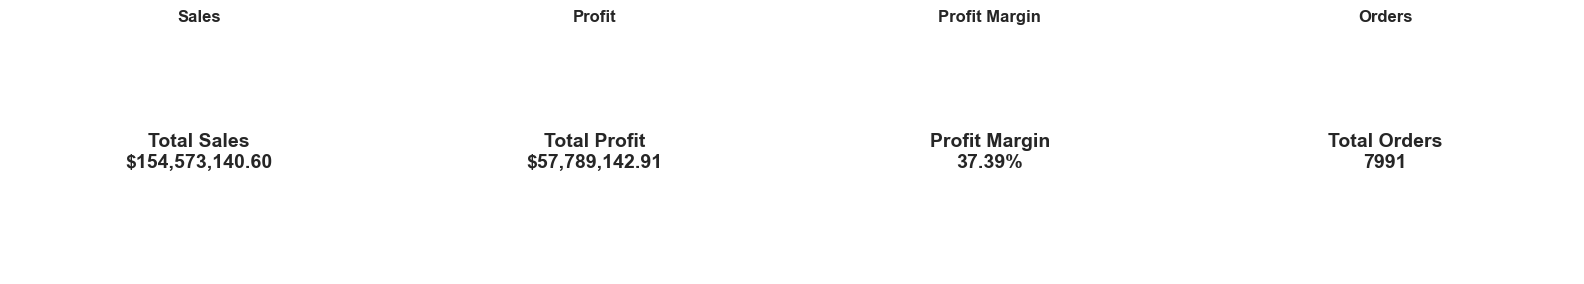

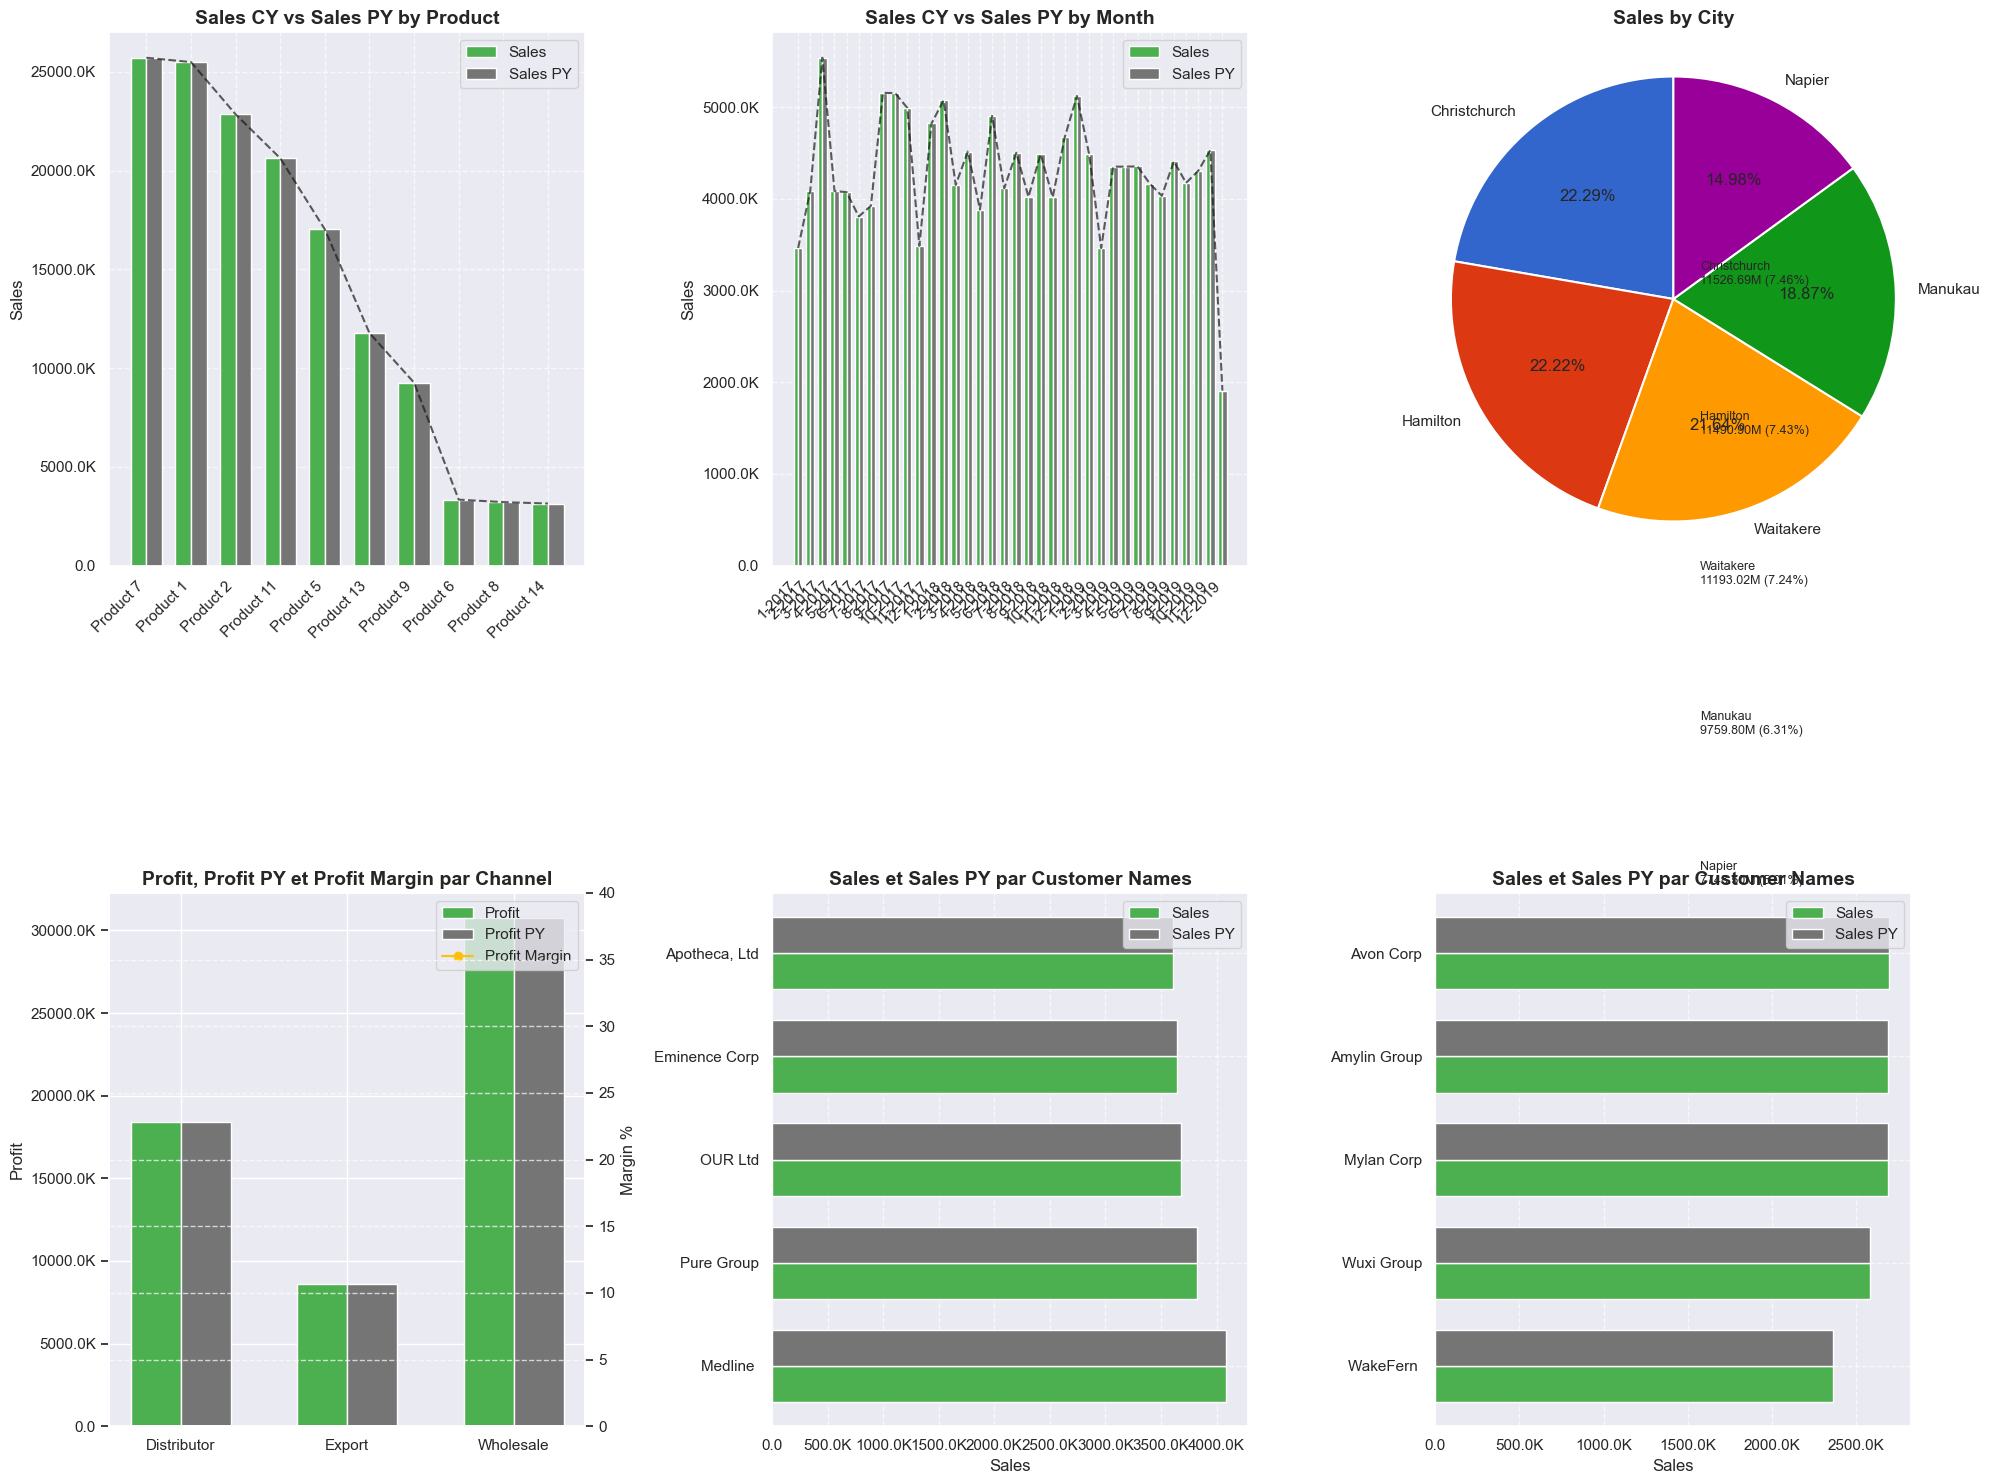

Total Sales: $154,573,140.60
Total Profit: $57,789,142.91
Profit Margin: 37.39%


In [38]:
if __name__ == "__main__":
    file_path = "data/sales.xlsx"
    results = run_sales_analysis(file_path)
    
    # Afficher les visualisations
    plt.figure(results['kpi_fig'].number)
    plt.figure(results['main_fig'].number)
    plt.show()

    results['main_fig'].savefig('images/sales_analysis.png', dpi=300, bbox_inches='tight')
    results['kpi_fig'].savefig('images/kpi_dashboard.png', dpi=300, bbox_inches='tight')
    
    results['sales_data'].to_excel('transformed_sales_data/transformed_sales_data.xlsx', index=False)
    results['measures']['monthly_measures'].to_csv('transformed_sales_data/monthly_sales.csv', index=False)
    
    # Afficher quelques statistiques clés
    print(f"Total Sales: ${results['measures']['total_sales']:,.2f}")
    print(f"Total Profit: ${results['measures']['total_profit']:,.2f}")
    print(f"Profit Margin: {results['measures']['profit_margin_pct']*100:.2f}%")